In [8]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/home/ubuntu/varios/skforecast'

In [9]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from astral.sun import sun
from astral import LocationInfo
from pprint import pprint
from skforecast.datasets import fetch_dataset


# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
pio.renderers.default = 'notebook' 
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')
from skforecast.plot import plot_residuals

# Modelling and Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from sklearn.preprocessing import PolynomialFeatures


# Warnings configuration
# ==============================================================================
import warnings

In [10]:
# Downloading data
# ==============================================================================
data = pd.read_csv(
    "https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast-datasets/main/data/vic_electricity.csv"
)
data

,Time,Demand,Temperature,Date,Holiday
0,2011-12-31T13:00:00Z,4382.825174,21.40,2012-01-01,True
1,2011-12-31T13:30:00Z,4263.365526,21.05,2012-01-01,True
2,2011-12-31T14:00:00Z,4048.966046,20.70,2012-01-01,True
3,2011-12-31T14:30:00Z,3877.563330,20.55,2012-01-01,True
4,2011-12-31T15:00:00Z,4036.229746,20.40,2012-01-01,True
...,...,...,...,...,...
52603,2014-12-31T10:30:00Z,3873.448714,19.00,2014-12-31,False
52604,2014-12-31T11:00:00Z,3791.637322,18.50,2014-12-31,False
52605,2014-12-31T11:30:00Z,3724.835666,17.70,2014-12-31,False
52606,2014-12-31T12:00:00Z,3761.886854,17.30,2014-12-31,False


In [11]:
# Preprocessing data (setting index and frequency)
# ==============================================================================
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()

# Aggregating in 1H intervals
# ==============================================================================
# The Date column is eliminated so that it does not generate an error when aggregating.
# The Holiday column does not generate an error since it is Boolean and is treated as 0-1.
data = data.drop(columns='Date')
data = data.resample(rule='H', closed='left', label ='right').mean()

data.head(2)

,Demand,Temperature,Holiday
Time,,,
2011-12-31 14:00:00,4323.095350,21.225,1.0
2011-12-31 15:00:00,3963.264688,20.625,1.0


In [12]:
# Calendar features
# ==============================================================================
calendar_features = pd.DataFrame(index=data.index)
calendar_features['month'] = calendar_features.index.month
calendar_features['week_of_year'] = calendar_features.index.isocalendar().week
calendar_features['week_day'] = calendar_features.index.day_of_week + 1
calendar_features['hour_day'] = calendar_features.index.hour + 1

# Sunlight features
# ==============================================================================
location = LocationInfo(
    "Melbourne",
    "Australia",
    latitude=-37.8,
    longitude=144.95,
    timezone='Australia/Melbourne'
)
sunrise_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunrise'].hour
    for date in data.index
]
sunset_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunset'].hour
    for date in data.index
]
sun_light_features = pd.DataFrame({
                         'sunrise_hour': sunrise_hour,
                         'sunset_hour': sunset_hour}, 
                         index = data.index
                     )
sun_light_features['daylight_hours'] = (
    sun_light_features['sunset_hour'] - sun_light_features['sunrise_hour']
)
sun_light_features['is_daylight'] = np.where(
                                        (data.index.hour >= sun_light_features['sunrise_hour']) & \
                                        (data.index.hour < sun_light_features['sunset_hour']),
                                        1,
                                        0
                                    )

# Holiday features
# ==============================================================================
holiday_features = data[['Holiday']].astype(int)
holiday_features['holiday_previous_day'] = holiday_features['Holiday'].shift(24)
holiday_features['holiday_next_day'] = holiday_features['Holiday'].shift(-24)

# Temperature features
# ==============================================================================
temp_features = data[['Temperature']].copy()
temp_features['temp_roll_mean_1_day'] = temp_features['Temperature'].rolling(24, closed='left').mean()
temp_features['temp_roll_mean_7_day'] = temp_features['Temperature'].rolling(24*7, closed='left').mean()
temp_features['temp_roll_max_1_day'] = temp_features['Temperature'].rolling(24, closed='left').max()
temp_features['temp_roll_min_1_day'] = temp_features['Temperature'].rolling(24, closed='left').min()
temp_features['temp_roll_max_7_day'] = temp_features['Temperature'].rolling(24*7, closed='left').max()
temp_features['temp_roll_min_7_day'] = temp_features['Temperature'].rolling(24*7, closed='left').min()


# Merge all exogenous variables
# ==============================================================================
exogenous_features = pd.concat([
                         calendar_features,
                         sun_light_features,
                         temp_features,
                         holiday_features
                     ], axis=1)

# Cliclical encoding of calendar and sunlight features
# ==============================================================================

def cyclical_encoding(data: pd.Series, cycle_length: int) -> pd.DataFrame:
    """
    Encode a cyclical feature with two new features sine and cosine.
    The minimum value of the feature is assumed to be 0. The maximum value
    of the feature is passed as an argument.
      
    Parameters
    ----------
    data : pd.Series
        Series with the feature to encode.
    cycle_length : int
        The length of the cycle. For example, 12 for months, 24 for hours, etc.
        This value is used to calculate the angle of the sin and cos.

    Returns
    -------
    result : pd.DataFrame
        Dataframe with the two new features sin and cos.

    """

    sin = np.sin(2 * np.pi * data/cycle_length)
    cos = np.cos(2 * np.pi * data/cycle_length)
    result =  pd.DataFrame({
                  f"{data.name}_sin": sin,
                  f"{data.name}_cos": cos
              })

    return result


month_encoded = cyclical_encoding(exogenous_features['month'], cycle_length=12)
week_of_year_encoded = cyclical_encoding(exogenous_features['week_of_year'], cycle_length=52)
week_day_encoded = cyclical_encoding(exogenous_features['week_day'], cycle_length=7)
hour_day_encoded = cyclical_encoding(exogenous_features['hour_day'], cycle_length=24)
sunrise_hour_encoded = cyclical_encoding(exogenous_features['sunrise_hour'], cycle_length=24)
sunset_hour_encoded = cyclical_encoding(exogenous_features['sunset_hour'], cycle_length=24)

cyclical_features = pd.concat([
                        month_encoded,
                        week_of_year_encoded,
                        week_day_encoded,
                        hour_day_encoded,
                        sunrise_hour_encoded,
                        sunset_hour_encoded
                    ], axis=1)

exogenous_features = pd.concat([exogenous_features, cyclical_features], axis=1)
exogenous_features.head(3)

# Interaction between exogenous variables
# ==============================================================================
transformer_poly = PolynomialFeatures(
                       degree           = 2,
                       interaction_only = True,
                       include_bias     = False
                   ).set_output(transform="pandas")

poly_cols = [
    'month_sin',
    'month_cos',
    'week_of_year_sin',
    'week_of_year_cos',
    'week_day_sin',
    'week_day_cos',
    'hour_day_sin',
    'hour_day_cos',
    'sunrise_hour_sin',
    'sunrise_hour_cos',
    'sunset_hour_sin',
    'sunset_hour_cos',
    'daylight_hours',
    'is_daylight',
    'holiday_previous_day',
    'holiday_next_day',
    'temp_roll_mean_1_day',
    'temp_roll_mean_7_day',
    'temp_roll_max_1_day',
    'temp_roll_min_1_day',
    'temp_roll_max_7_day',
    'temp_roll_min_7_day',
    'Temperature',
    'Holiday'
]

poly_features = transformer_poly.fit_transform(exogenous_features[poly_cols].dropna())
poly_features = poly_features.drop(columns=poly_cols)
poly_features.columns = [f"poly_{col}" for col in poly_features.columns]
poly_features.columns = poly_features.columns.str.replace(" ", "__")
exogenous_features = pd.concat([exogenous_features, poly_features], axis=1)

In [13]:
# Select exogenous variables to be included in the model
# ==============================================================================
exog_features = []
# Columns that ends with _sin or _cos are selected
exog_features.extend(exogenous_features.filter(regex='_sin$|_cos$').columns.tolist())
# Columns that start with temp_ are selected
exog_features.extend(exogenous_features.filter(regex='^temp_.*').columns.tolist())
# Columns that start with holiday_ are selected
exog_features.extend(exogenous_features.filter(regex='^holiday_.*').columns.tolist())
# Include original features
exog_features.extend(['Temperature', 'Holiday'])

data = data[['Demand']].merge(
           exogenous_features[exog_features],
           left_index=True,
           right_index=True,
           how='left'
       )
data = data.dropna()
data = data.astype('float32')

To facilitate the training of the models, the search for optimal hyperparameters and the evaluation of their predictive accuracy, the data are divided into three separate sets: training, validation and test.

In [14]:
# Split data into train-val-test
# ==============================================================================
data = data.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00'].copy()
end_train = '2013-12-31 23:59:00'
end_validation = '2014-11-30 23:59:00'
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2012-01-07 14:00:00 --- 2013-12-31 23:00:00  (n=17386)
Validation dates : 2014-01-01 00:00:00 --- 2014-11-30 23:00:00  (n=8016)
Test dates       : 2014-12-01 00:00:00 --- 2014-12-30 13:00:00  (n=710)


In [15]:
# Interactive plot of time series
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['Demand'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=data_val.index, y=data_val['Demand'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['Demand'], mode='lines', name='Test'))
fig.update_layout(
    title  = 'Number of users',
    xaxis_title="Time",
    yaxis_title="Users",
    legend_title="Partition:",
    width=900,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
#fig.update_xaxes(rangeslider_visible=True)
fig.show()

## Prediction intervals

In [191]:
# Create forecaster with the selected features
# ==============================================================================

#regressor = Ridge()

regressor = LGBMRegressor(
                n_estimators=1100,
                max_depth=10,
                learning_rate=0.0709,
                reg_alpha=0.8,
                reg_lambda=0.2,
                random_state=15926,
                verbose=-1
            )

forecaster = ForecasterAutoreg(
                 regressor = regressor,
                 lags      = 24
             )

In [192]:
def plot_predicted_intervals(
    predictions: pd.DataFrame,
    y_true: pd.DataFrame,
    target_variable: str,
):
    """
    Plot predicted intervals vs real values

    Parameters
    ----------
    predictions : pd.DataFrame
        Predicted values and intervals.
    y_true : pd.DataFrame
        Real values of target variable.
    target_variable : str
        Name of target variable.
    """

    fig = go.Figure([
        go.Scatter(name='Prediction', x=predictions.index, y=predictions['pred'], mode='lines'),
        go.Scatter(name='Real value', x=y_true.index, y=y_true[target_variable], mode='lines'),
        go.Scatter(
            name='Upper Bound', x=predictions.index, y=predictions['upper_bound'],
            mode='lines', marker=dict(color="#444"), line=dict(width=0), showlegend=False
        ),
        go.Scatter(
            name='Lower Bound', x=predictions.index, y=predictions['lower_bound'],
            marker=dict(color="#444"), line=dict(width=0), mode='lines',
            fillcolor='rgba(68, 68, 68, 0.3)', fill='tonexty', showlegend=False
        )
    ])
    fig.update_layout(
        title="Real value vs predicted in test data",
        xaxis_title="Date time",
        yaxis_title=target_variable,
        width=900,
        height=400,
        margin=dict(l=20, r=20, t=35, b=20),
        hovermode="x",
        legend=dict(
            orientation="h",
            yanchor="top",
            y=1.1,
            xanchor="left",
            x=0.001
        )
    )
    fig.show()

## In sample residuals

By default, intervals are calculated using in-sample residuals (residuals from the training set). However, this can result in intervals that are too narrow (overly optimistic).

In [193]:
# Backtesting with prediction intervals in test data using in-sample residuals
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster          = forecaster,
                          y                   = data['Demand'], # Full dataset
                          exog                = data[exog_features],
                          steps               = 24,
                          metric              = 'mean_absolute_error',
                          initial_train_size  = len(data.loc[:end_validation]),
                          refit               = False,
                          interval            = [10, 90], # 80% prediction interval
                          n_boot              = 100,
                          in_sample_residuals = True, # Use in-sample residuals
                          binned_residuals    = False,
                          n_jobs              = 'auto',
                          verbose             = False,
                          show_progress       = True
                      )
predictions.head(5)

100%|██████████| 30/30 [00:08<00:00,  3.64it/s]


,pred,lower_bound,upper_bound
2014-12-01 00:00:00,5616.805505,5476.786560,5753.583994
2014-12-01 01:00:00,5529.007504,5295.339888,5810.688608
2014-12-01 02:00:00,5410.488581,5143.700357,5753.535540
2014-12-01 03:00:00,5361.247274,5018.963124,5741.622698
2014-12-01 04:00:00,5464.813071,5132.851886,5890.086110


In [194]:
# Predicted interval coverage (on test data)
# ==============================================================================
inside_interval = np.where(
                      (data.loc[end_validation:, 'Demand'] >= predictions["lower_bound"]) & \
                      (data.loc[end_validation:, 'Demand'] <= predictions["upper_bound"]),
                      True,
                      False 
                  )

coverage = inside_interval.mean()
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

# Area between the upper and lower bounds
# ==============================================================================
area = predictions['upper_bound'] - predictions['lower_bound']
area = area.sum()
print(f"Area between the upper and lower bounds: {round(area, 2)}")

# Plot
# ==============================================================================
plot_predicted_intervals(
    predictions=predictions,
    y_true=data_test,
    target_variable='Demand',
)

Predicted interval coverage: 80.7 %
Area between the upper and lower bounds: 599778.3


The prediction intervals exhibit overconfidence as they tend to be excessively narrow, resulting in a true coverage that falls below the nominal coverage. This phenomenon arises from the tendency of in-sample residuals to often overestimate the predictive capacity of the model.

## Out sample residuals (non-conditioned on predicted values)

The `set_out_sample_residuals()` method is used to specify out-sample residuals computed with a validation set through backtesting.

In [195]:
# Backtesting on validation data to obtain out-sample residuals
# ==============================================================================
_, predictions_val = backtesting_forecaster(
                         forecaster         = forecaster,
                         y                  = data.loc[:end_validation, 'Demand'], # Train + Validation
                         exog               = data.loc[:end_validation, exog_features],
                         steps              = 24,
                         metric             = 'mean_absolute_error',
                         initial_train_size = len(data.loc[:end_train]),
                         refit              = False,
                         n_jobs             = 'auto',
                         verbose            = False,
                         show_progress      = True
                     )
residuals = data.loc[predictions_val.index, 'Demand'] - predictions_val['pred']
residuals = residuals.dropna()

100%|██████████| 334/334 [00:01<00:00, 282.74it/s]


negative    4818
positive    3198
Name: count, dtype: int64


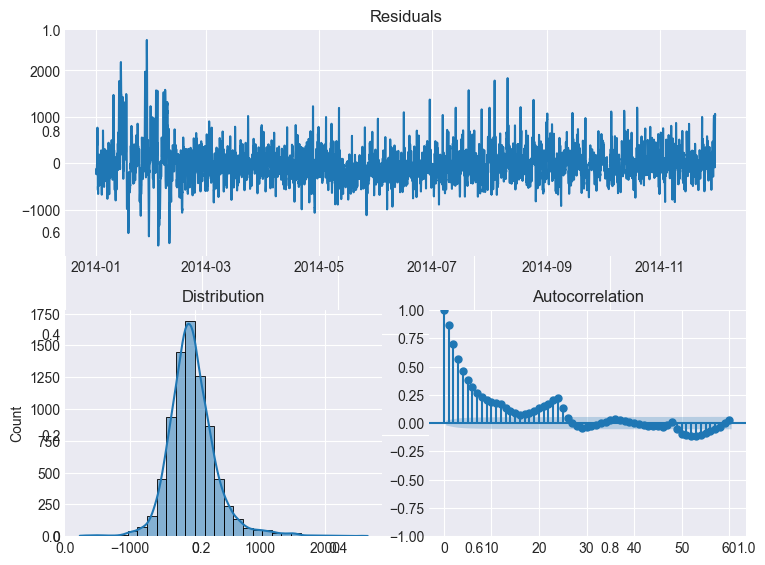

In [196]:
# Out-sample residuals distribution
# ==============================================================================
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
fig, ax = plt.subplots(figsize=(8, 6))
_ = plot_residuals(residuals=residuals, fig=fig)
fig.tight_layout()

In [197]:
# Store out-sample residuals in the forecaster
# ==============================================================================
forecaster.fit(y=data_train['Demand'], exog=data_train[exog_features])
forecaster.set_out_sample_residuals(residuals=residuals)

In [198]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster          = forecaster,
                          y                   = data['Demand'], # Full dataset
                          exog                = data[exog_features],
                          steps               = 24,
                          metric              = 'mean_absolute_error',
                          initial_train_size  = len(data.loc[:end_validation]),
                          refit               = False,
                          interval            = [10, 90], # 80% prediction interval
                          n_boot              = 100,
                          in_sample_residuals = False, # Use out-sample residuals
                          binned_residuals    = False,
                          n_jobs              = 'auto',
                          verbose             = False,
                          show_progress       = True
                      )
predictions.head(5)

100%|██████████| 30/30 [00:08<00:00,  3.73it/s]


,pred,lower_bound,upper_bound
2014-12-01 00:00:00,5616.805505,5166.513547,5943.604307
2014-12-01 01:00:00,5529.007504,4725.355759,5992.899443
2014-12-01 02:00:00,5410.488581,4281.735592,6240.009065
2014-12-01 03:00:00,5361.247274,4096.461303,6032.590401
2014-12-01 04:00:00,5464.813071,4138.304249,6107.963830


In [199]:
# Predicted interval coverage (on test data)
# ==============================================================================
inside_interval = np.where(
                      (data.loc[end_validation:, 'Demand'] >= predictions["lower_bound"]) & \
                      (data.loc[end_validation:, 'Demand'] <= predictions["upper_bound"]),
                      True,
                      False 
                  )

coverage = inside_interval.mean()
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = predictions['upper_bound'] - predictions['lower_bound']
area = area.sum()
print(f"Total area of the interval: {round(area, 2)}")

# Ploc
# ==============================================================================
plot_predicted_intervals(
    predictions=predictions,
    y_true=data_test,
    target_variable='Demand',
)

Predicted interval coverage: 95.07 %
Total area of the interval: 1381587.25


The resulting prediction intervals derived from out-of-sample residuals show increased width compared to those generated using in-sample residuals. Interestingly, in this scenario, the true coverage exceeds the nominal coverage. Examining the plot, we see that the intervals are particularly wide when the predicted values are low. This is due to the fact that the out-of-sample residuals are selected at random, assuming that they are independent of the predicted values. This is not the case.

## Out sample residuals (conditioned on predicted values)

To account for the dependence between the residuals and the predicted values, the predicted values are passed to the `set_out_sample_residuals()` method in addition to the residuals. The binning process can be adjusted using the argument `binner_kwargs` of the forecast object.

In [221]:
binner_kwargs={'n_bins': 20, 'encode': 'ordinal', 'strategy': 'quantile', 'subsample': 10000}

forecaster = ForecasterAutoreg(
                 regressor     = regressor,
                 lags          = 24,
                 binner_kwargs = binner_kwargs
             )

In [222]:
# Backtesting on validation data to obtain out-sample residuals
# ==============================================================================
_, predictions_val = backtesting_forecaster(
                         forecaster         = forecaster,
                         y                  = data.loc[:end_validation, 'Demand'], # Train + Validation
                         exog               = data.loc[:end_validation, exog_features],
                         steps              = 24,
                         metric             = 'mean_absolute_error',
                         initial_train_size = len(data.loc[:end_train]),
                         refit              = False,
                         n_jobs             = 'auto',
                         verbose            = False,
                         show_progress      = True
                     )
residuals = data.loc[predictions_val.index, 'Demand'] - predictions_val['pred']
residuals = residuals.dropna()

# Store out-sample residuals in the forecaster 
# ==============================================================================
forecaster.fit(y=data_train['Demand'], exog=data_train[exog_features])
forecaster.set_out_sample_residuals(residuals=residuals, y_pred=predictions_val['pred'])

100%|██████████| 334/334 [00:00<00:00, 367.80it/s]


In [223]:
# Intervals of the residual binning
# ==============================================================================
pprint(forecaster.binner_intervals)

{0: (2972.3627442202583, 3481.5078161306888),
 1: (3481.5078161306888, 3641.7592639364047),
 2: (3641.7592639364047, 3774.9568218061304),
 3: (3774.9568218061304, 3886.511455834099),
 4: (3886.511455834099, 4000.2062268431346),
 5: (4000.2062268431346, 4106.849901041821),
 6: (4106.849901041821, 4216.146454048187),
 7: (4216.146454048187, 4343.245938627354),
 8: (4343.245938627354, 4489.633068310191),
 9: (4489.633068310191, 4649.852681250619),
 10: (4649.852681250619, 4805.631111833305),
 11: (4805.631111833305, 4944.721228189146),
 12: (4944.721228189146, 5058.548215803162),
 13: (5058.548215803162, 5174.630196539151),
 14: (5174.630196539151, 5300.73388798104),
 15: (5300.73388798104, 5437.922414937319),
 16: (5437.922414937319, 5597.959533474054),
 17: (5597.959533474054, 5808.51691727834),
 18: (5808.51691727834, 6123.199796021716),
 19: (6123.199796021716, 8235.497352014376)}


In [224]:
for k, v in forecaster.out_sample_residuals_by_bin.items():
    print(f" Bin {k}: n={len(v)}")

 Bin 0: n=200
 Bin 1: n=200
 Bin 2: n=200
 Bin 3: n=200
 Bin 4: n=200
 Bin 5: n=200
 Bin 6: n=200
 Bin 7: n=200
 Bin 8: n=200
 Bin 9: n=200
 Bin 10: n=200
 Bin 11: n=200
 Bin 12: n=200
 Bin 13: n=200
 Bin 14: n=200
 Bin 15: n=200
 Bin 16: n=200
 Bin 17: n=200
 Bin 18: n=200
 Bin 19: n=200


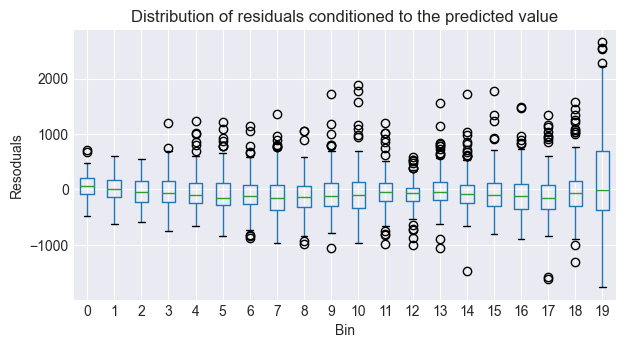

In [225]:
# Distribution of the residual per bin (boxplot)
# ==============================================================================
out_sample_residuals_by_bin_df = pd.DataFrame(
    dict([(k, pd.Series(v)) for k,v in forecaster.out_sample_residuals_by_bin.items()])
)
fig, ax = plt.subplots(figsize=(7, 3.5))
out_sample_residuals_by_bin_df.boxplot(ax=ax)
ax.set_title("Distribution of residuals conditioned to the predicted value")
ax.set_xlabel("Bin")
ax.set_ylabel("Resoduals");

In [226]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster          = forecaster,
                          y                   = data['Demand'], # Full dataset
                          exog                = data[exog_features],
                          steps               = 24,
                          metric              = 'mean_absolute_error',
                          initial_train_size  = len(data.loc[:end_validation]),
                          refit               = False,
                          interval            = [10, 90], # 80% prediction interval
                          n_boot              = 100,
                          in_sample_residuals = False, # Use out-sample residuals
                          binned_residuals    = True,
                          n_jobs              = 'auto',
                          verbose             = False,
                          show_progress       = True
                      )
predictions.head(5)

100%|██████████| 30/30 [00:12<00:00,  2.43it/s]


,pred,lower_bound,upper_bound
2014-12-01 00:00:00,5616.805505,5138.950542,5844.818698
2014-12-01 01:00:00,5529.007504,4813.955789,6013.726246
2014-12-01 02:00:00,5410.488581,4393.373825,5897.511059
2014-12-01 03:00:00,5361.247274,4146.004587,5898.272388
2014-12-01 04:00:00,5464.813071,4470.470339,6010.859101


In [227]:
# Predicted interval coverage (on test data)
# ==============================================================================
inside_interval = np.where(
                      (data.loc[end_validation:, 'Demand'] >= predictions["lower_bound"]) & \
                      (data.loc[end_validation:, 'Demand'] <= predictions["upper_bound"]),
                      True,
                      False 
                  )

coverage = inside_interval.mean()
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = predictions['upper_bound'] - predictions['lower_bound']
area = area.sum()
print(f"Total area of the interval: {round(area, 2)}")

# Ploc
# ==============================================================================
plot_predicted_intervals(
    predictions=predictions,
    y_true=data_test,
    target_variable='Demand',
)

Predicted interval coverage: 98.31 %
Total area of the interval: 1164132.88


When using out-of-sample residuals conditioned on the predicted value, the coverage of the predicted intervals closely matches the nominal coverage. In addition, these intervals have a narrower range than those obtained using out-of-sample residuals not conditioned on the predicted value. This implies that the intervals achieve the desired coverage with reduced uncertainty.